In [1]:
# Install necessary requirements

# If you run this notebook on Google Colab, or in standalone mode, you need to install the required packages.
# Uncomment the following lines:

# !pip install choice-learn

# If you run the notebook within the GitHub repository, you need to run the following lines, that can skipped otherwise:
import os
import sys

sys.path.append("../../")

In [2]:
import os
# Remove/Add GPU use
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from choice_learn.data import ChoiceDataset
from choice_learn.models import RUMnet

2025-03-24 17:35:23.023975: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 17:35:23.024601: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 17:35:23.026641: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 17:35:23.032892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-24 17:35:23.045907: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

In [3]:
dataset = pd.read_csv("data_full_anonym.csv")
dataset.head()

,individual,alternative,choice,officeID,depWeekDay,OD,fAirline,staySaturday,stayDurationMinutes,totalPrice,totalTripDurationMinutes,dtd,nAirlines,nFlights,isContinental,isDomestic,outDepTime_sin,outDepTime_cos,outArrTime_sin,outArrTime_cos
0,91,19,1,1,2,22,36,1.0,18660.0,230.029999,735.0,23.0,1.0,4.0,1.0,0.0,0.737277,-0.675590,-0.854912,0.518773
1,91,20,0,1,2,22,36,1.0,18235.0,230.029999,1160.0,23.0,1.0,4.0,1.0,0.0,0.737277,-0.675590,-0.854912,0.518773
2,91,21,0,1,2,22,30,1.0,17855.0,247.809998,920.0,24.0,1.0,4.0,1.0,0.0,-0.999762,-0.021815,-0.976296,0.216440
3,91,22,0,1,2,22,30,1.0,17855.0,247.809998,1135.0,24.0,1.0,4.0,1.0,0.0,-0.999762,-0.021815,-0.402747,0.915311
4,91,23,0,1,2,22,30,1.0,280.0,247.809998,1135.0,24.0,1.0,4.0,1.0,0.0,-0.999762,-0.021815,-0.976296,0.216440


In [4]:
dataset[["officeID", "OD"]] = dataset[["officeID", "OD"]].astype(np.float32)

In [5]:
from choice_learn.data import ChoiceDataset

dataset = ChoiceDataset.from_single_long_df(
    df=dataset,
    shared_features_columns=["officeID", "OD"],
    items_features_columns=["fAirline", "staySaturday", "stayDurationMinutes", "totalPrice",
            "totalTripDurationMinutes", "dtd", "nAirlines", "nFlights", "depWeekDay",
            "isContinental", "isDomestic", "outDepTime_sin", "outDepTime_cos",
            "outArrTime_sin", "outArrTime_cos"],
    items_id_column="alternative",
    choices_id_column="individual",
    choices_column="choice",
    choice_format="one_zero"
)


In [6]:
model_args = {
    "num_products_features": 15,
    "num_customer_features": 2,
    "width_eps_x": 20,
    "depth_eps_x": 5,
    "heterogeneity_x": 10,
    "width_eps_z": 20,
    "depth_eps_z": 5,
    "heterogeneity_z": 10,
    "width_u": 20,
    "depth_u": 5,
    "optimizer": "Adam",
    "lr": 0.0002,
    "logmin": 1e-10,
    "label_smoothing": 0.02,
    "callbacks": [],
    "epochs": 100,
    "batch_size": 32,
    "tol": 0,
}

In [7]:
indexes = np.random.permutation(list(range(len(dataset))))

fit_losses = []
test_eval = []
for i in range(5):
    test_indexes = indexes[int(len(indexes) * 0.2 * i):int(len(indexes) * 0.2 * (i + 1))]
    train_indexes = np.concatenate([indexes[:int(len(indexes) * 0.2 * i)],
                                    indexes[int(len(indexes) * 0.2 * (i + 1)):]],
                                   axis=0)

    train_dataset = dataset[train_indexes]
    test_dataset = dataset[test_indexes]

    model = RUMnet(**model_args)
    model.instantiate()

    # print(train_dataset)
    # print(test_dataset)
    
    losses = model.fit(train_dataset, val_dataset=test_dataset)
    probas = model.predict_probas(test_dataset)
    # eval = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_pred=model.predict_probas(test_dataset), y_true=tf.one_hot(test_dataset.choices, 3))
    num_classes = model.predict_probas(test_dataset).shape[1]  # Get correct class count
    eval = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(
        y_pred=model.predict_probas(test_dataset), 
        y_true=tf.one_hot(test_dataset.choices, num_classes)
    )
    test_eval.append(eval)
    print(test_eval)

    fit_losses.append(losses)

Epoch 99 Train Loss 2.5985: 100%|████| 100/100 [2:39:51<00:00, 95.91s/it]


[<tf.Tensor: shape=(), dtype=float32, numpy=2.3434737>]


Epoch 99 Train Loss 2.6013: 100%|████| 100/100 [2:32:13<00:00, 91.33s/it]


[<tf.Tensor: shape=(), dtype=float32, numpy=2.3434737>, <tf.Tensor: shape=(), dtype=float32, numpy=2.3250525>]


Epoch 99 Train Loss 2.6064: 100%|████| 100/100 [2:35:13<00:00, 93.14s/it]


[<tf.Tensor: shape=(), dtype=float32, numpy=2.3434737>, <tf.Tensor: shape=(), dtype=float32, numpy=2.3250525>, <tf.Tensor: shape=(), dtype=float32, numpy=2.305025>]


Epoch 99 Train Loss 2.5924: 100%|████| 100/100 [2:34:57<00:00, 92.97s/it]


[<tf.Tensor: shape=(), dtype=float32, numpy=2.3434737>, <tf.Tensor: shape=(), dtype=float32, numpy=2.3250525>, <tf.Tensor: shape=(), dtype=float32, numpy=2.305025>, <tf.Tensor: shape=(), dtype=float32, numpy=2.3142292>]


Epoch 99 Train Loss 2.5927: 100%|████| 100/100 [2:35:48<00:00, 93.49s/it]


[<tf.Tensor: shape=(), dtype=float32, numpy=2.3434737>, <tf.Tensor: shape=(), dtype=float32, numpy=2.3250525>, <tf.Tensor: shape=(), dtype=float32, numpy=2.305025>, <tf.Tensor: shape=(), dtype=float32, numpy=2.3142292>, <tf.Tensor: shape=(), dtype=float32, numpy=2.3102>]


In [8]:
fit_losses_copy = fit_losses
test_dataset_copy = test_dataset
model_copy = model

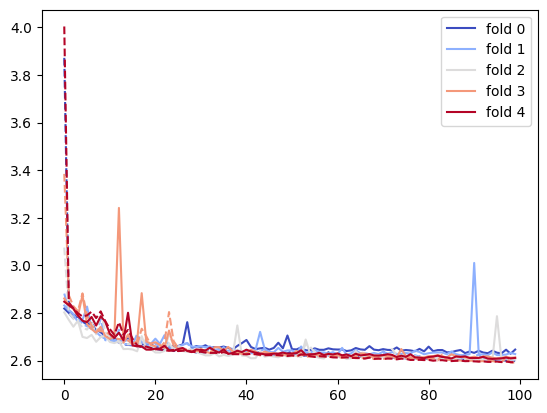

In [9]:
cmap = plt.cm.coolwarm
colors = [cmap(j / 4) for j in range(5)]
for i in range(len(fit_losses)):
    plt.plot(fit_losses[i]["train_loss"], c=colors[i], linestyle="--")
    plt.plot(fit_losses[i]["test_loss"], label=f"fold {i}", c=colors[i])
plt.legend()

In [10]:
model.evaluate(test_dataset)

<tf.Tensor: shape=(), dtype=float32, numpy=2.3102176>

In [11]:
print("Average LogLikeliHood on test:", np.mean(test_eval))

Average LogLikeliHood on test: 2.319596


In [12]:
y_true = test_dataset.choices  # True labels
y_pred = model.predict_probas(test_dataset)  # Predicted probabilities
top1_preds = np.argmax(y_pred, axis=1)  # Get index of max probability
top1_acc = np.mean(top1_preds == y_true)  # Compute accuracy
print("Top-1 Accuracy:", top1_acc)

Top-1 Accuracy: 0.2691797967898689


In [13]:
top5_preds = np.argsort(y_pred, axis=1)[:, -5:]  # Get indices of top 5 predictions
top5_acc = np.mean([y_true[i] in top5_preds[i] for i in range(len(y_true))])
print("Top-5 Accuracy:", top5_acc)

Top-5 Accuracy: 0.6717714622294213
